In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from joblib import parallel_backend
from project_functions.modeling import run_model
from project_functions.utils import picklify, unpickle
import pickle

In [2]:
# df = pd.read_parquet('../data/cleaned/tokenized_data_large_genres.parquet')

In [3]:
X_train_count_unigrams = unpickle('../data/cleaned/train/X_train_count_unigrams.pickle')
X_test_count_unigrams = unpickle('../data/cleaned/test/X_test_count_unigrams.pickle')
X_train_count_bigrams = unpickle('../data/cleaned/train/X_train_count_bigrams.pickle')
X_test_count_bigrams = unpickle('../data/cleaned/test/X_test_count_bigrams.pickle')
X_train_gensim_2gram_sparse = unpickle('../data/cleaned/train/X_train_gensim_2gram_sparse.pickle').T
X_test_gensim_2gram_sparse = unpickle('../data/cleaned/test/X_test_gensim_2gram_sparse.pickle').T
X_train_gensim_3gram_sparse = unpickle('../data/cleaned/train/X_train_gensim_3gram_sparse.pickle').T
X_test_gensim_3gram_sparse = unpickle('../data/cleaned/test/X_test_gensim_3gram_sparse.pickle').T
X_train_gensim_4gram_sparse = unpickle('../data/cleaned/train/X_train_gensim_4gram_sparse.pickle').T
X_test_gensim_4gram_sparse = unpickle('../data/cleaned/test/X_test_gensim_4gram_sparse.pickle').T
y_train = unpickle('../data/cleaned/train/y_train.pickle')
y_test = unpickle('../data/cleaned/test/y_test.pickle')

Score: 0.35695014662756597
              precision    recall  f1-score   support

           0       0.24      0.34      0.29       911
           1       0.36      0.46      0.40       639
           2       0.53      0.55      0.54       840
           3       0.30      0.20      0.24      1014
           4       0.25      0.28      0.26       601
           5       0.39      0.45      0.41       969
           6       0.20      0.09      0.13       896
           7       0.36      0.32      0.34       690
           8       0.47      0.78      0.59       917
           9       0.28      0.14      0.19      1048

    accuracy                           0.36      8525
   macro avg       0.34      0.36      0.34      8525
weighted avg       0.34      0.36      0.34      8525



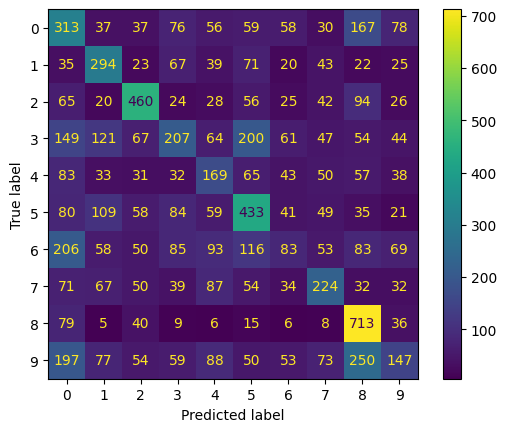

In [4]:
mnb_count_unigrams = run_model(X_train_count_unigrams, X_test_count_unigrams, y_train, y_test,
                             MultinomialNB(), plot_confusion = True, display_report = True,
                             pickle_ = True, pickle_dest = '../data/models/mnb_count_unigrams.pickle')

Score: 0.35577712609970674
              precision    recall  f1-score   support

           0       0.24      0.36      0.29       911
           1       0.35      0.45      0.39       639
           2       0.54      0.55      0.54       840
           3       0.32      0.20      0.24      1014
           4       0.25      0.28      0.26       601
           5       0.39      0.46      0.42       969
           6       0.19      0.08      0.11       896
           7       0.36      0.32      0.34       690
           8       0.46      0.79      0.58       917
           9       0.28      0.12      0.17      1048

    accuracy                           0.36      8525
   macro avg       0.34      0.36      0.34      8525
weighted avg       0.34      0.36      0.33      8525



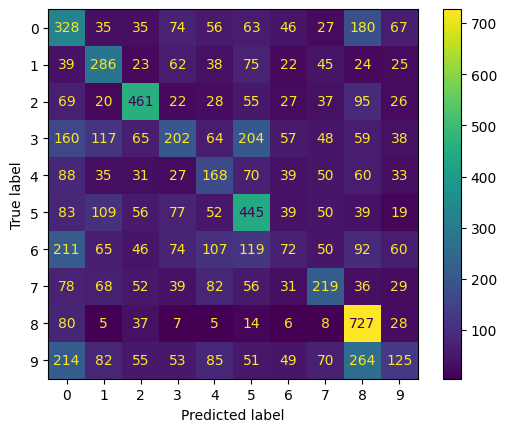

In [5]:
mnb_count_bigrams = run_model(X_train_count_bigrams, X_test_count_bigrams, y_train, y_test,
                             MultinomialNB(), plot_confusion = True, display_report = True,
                             pickle_ = True, pickle_dest = '../data/models/mnb_count_bigrams.pickle')

Score: 0.5018181818181818
              precision    recall  f1-score   support

           0       0.33      0.36      0.35       911
           1       0.50      0.52      0.51       639
           2       0.75      0.73      0.74       840
           3       0.49      0.50      0.50      1014
           4       0.38      0.40      0.39       601
           5       0.63      0.58      0.60       969
           6       0.25      0.32      0.28       896
           7       0.82      0.47      0.60       690
           8       0.65      0.80      0.72       917
           9       0.43      0.33      0.37      1048

    accuracy                           0.50      8525
   macro avg       0.52      0.50      0.51      8525
weighted avg       0.52      0.50      0.50      8525



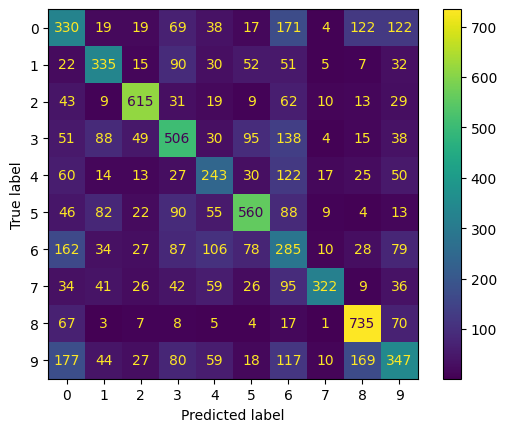

In [6]:
mnb_gensim_2gram = run_model(X_train_gensim_2gram_sparse, X_test_gensim_2gram_sparse, y_train, y_test,
                             MultinomialNB(), plot_confusion = True, display_report = True,
                             pickle_ = True, pickle_dest = '../data/models/mnb_gensim_2gram.pickle')

Score: 0.5019354838709678
              precision    recall  f1-score   support

           0       0.35      0.36      0.35       911
           1       0.52      0.53      0.52       639
           2       0.74      0.73      0.74       840
           3       0.48      0.48      0.48      1014
           4       0.38      0.40      0.39       601
           5       0.57      0.61      0.59       969
           6       0.26      0.31      0.28       896
           7       0.81      0.47      0.59       690
           8       0.65      0.80      0.72       917
           9       0.42      0.33      0.37      1048

    accuracy                           0.50      8525
   macro avg       0.52      0.50      0.50      8525
weighted avg       0.51      0.50      0.50      8525



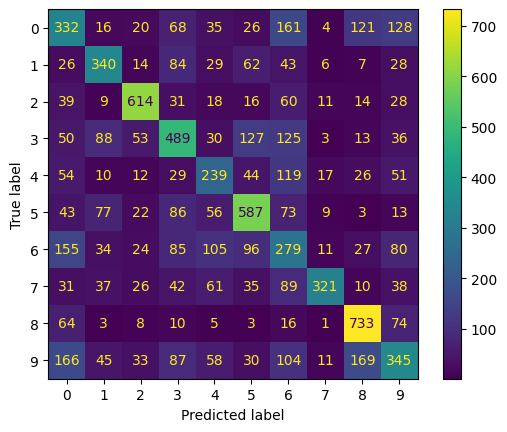

In [7]:
mnb_gensim_3gram = run_model(X_train_gensim_3gram_sparse, X_test_gensim_3gram_sparse, y_train, y_test,
                             MultinomialNB(), plot_confusion = True, display_report = True,
                             pickle_ = True, pickle_dest = '../data/models/mnb_gensim_3gram.pickle')

Score: 0.5005278592375366
              precision    recall  f1-score   support

           0       0.35      0.36      0.36       911
           1       0.49      0.52      0.51       639
           2       0.75      0.73      0.74       840
           3       0.48      0.49      0.48      1014
           4       0.38      0.39      0.39       601
           5       0.61      0.59      0.60       969
           6       0.24      0.32      0.28       896
           7       0.83      0.46      0.60       690
           8       0.66      0.80      0.72       917
           9       0.42      0.32      0.37      1048

    accuracy                           0.50      8525
   macro avg       0.52      0.50      0.50      8525
weighted avg       0.52      0.50      0.50      8525



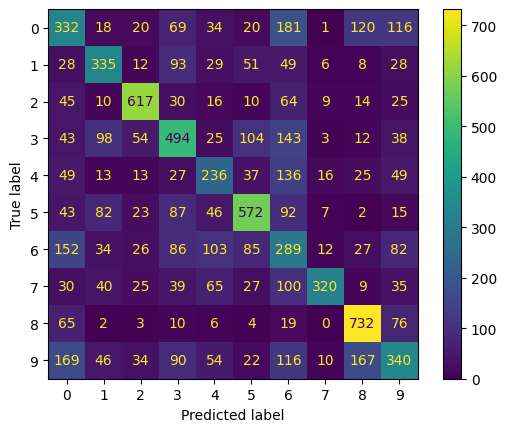

In [8]:
mnb_gensim_4gram = run_model(X_train_gensim_4gram_sparse, X_test_gensim_4gram_sparse, y_train, y_test,
                             MultinomialNB(), plot_confusion = True, display_report = True,
                             pickle_ = True, pickle_dest = '../data/models/mnb_gensim_4gram.pickle')

Score: 0.49478005865102637
              precision    recall  f1-score   support

           0       0.31      0.41      0.35       911
           1       0.55      0.48      0.51       639
           2       0.70      0.71      0.70       840
           3       0.50      0.51      0.51      1014
           4       0.47      0.37      0.41       601
           5       0.53      0.61      0.57       969
           6       0.26      0.21      0.23       896
           7       0.79      0.51      0.62       690
           8       0.64      0.71      0.67       917
           9       0.39      0.40      0.39      1048

    accuracy                           0.49      8525
   macro avg       0.51      0.49      0.50      8525
weighted avg       0.50      0.49      0.49      8525



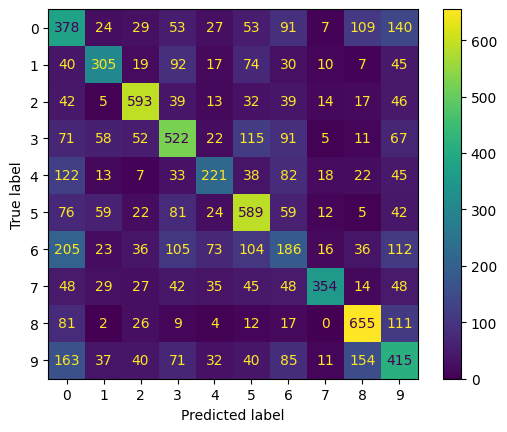

In [9]:
baseline_xg_gensim_2gram = run_model(X_train_gensim_2gram_sparse, X_test_gensim_2gram_sparse, y_train, y_test,
                             XGBClassifier(), plot_confusion = True, display_report = True,
                             pickle_ = True, pickle_dest = '../data/models/baseline_xg_gensim_2gram.pickle')

Score: 0.4946627565982405
              precision    recall  f1-score   support

           0       0.30      0.41      0.35       911
           1       0.56      0.49      0.52       639
           2       0.70      0.72      0.71       840
           3       0.48      0.50      0.49      1014
           4       0.47      0.37      0.42       601
           5       0.54      0.61      0.57       969
           6       0.26      0.20      0.23       896
           7       0.78      0.52      0.62       690
           8       0.64      0.72      0.68       917
           9       0.38      0.39      0.39      1048

    accuracy                           0.49      8525
   macro avg       0.51      0.49      0.50      8525
weighted avg       0.50      0.49      0.49      8525



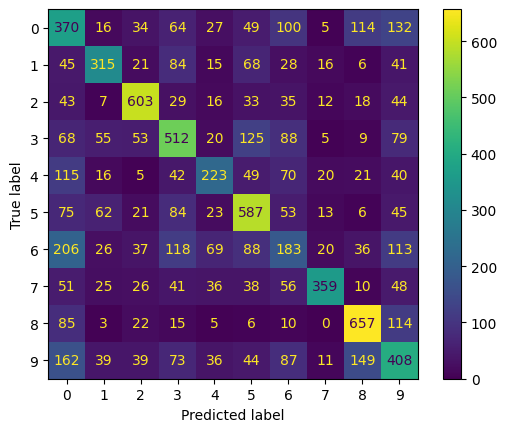

In [10]:
baseline_xg_gensim_3gram = run_model(X_train_gensim_3gram_sparse, X_test_gensim_3gram_sparse, y_train, y_test,
                             XGBClassifier(), plot_confusion = True, display_report = True,
                             pickle_ = True, pickle_dest = '../data/models/baseline_xg_gensim_3gram.pickle')

Score: 0.49853372434017595
              precision    recall  f1-score   support

           0       0.30      0.42      0.35       911
           1       0.55      0.49      0.52       639
           2       0.72      0.70      0.71       840
           3       0.49      0.51      0.50      1014
           4       0.48      0.38      0.42       601
           5       0.56      0.61      0.58       969
           6       0.27      0.22      0.25       896
           7       0.79      0.53      0.64       690
           8       0.63      0.72      0.67       917
           9       0.38      0.38      0.38      1048

    accuracy                           0.50      8525
   macro avg       0.52      0.50      0.50      8525
weighted avg       0.51      0.50      0.50      8525



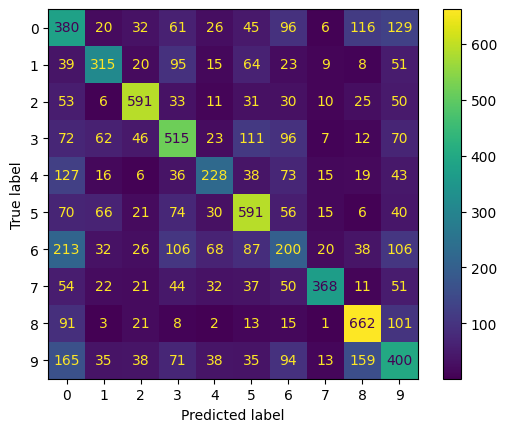

In [11]:
baseline_xg_gensim_4gram = run_model(X_train_gensim_4gram_sparse, X_test_gensim_4gram_sparse, y_train, y_test,
                             XGBClassifier(), plot_confusion = True, display_report = True,
                             pickle_ = True, pickle_dest = '../data/models/baseline_xg_gensim_4gram.pickle')

In [12]:
params = {
    'n_estimators': [1000],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample':[1],
    'colsample_bytree':[1],
    'alpha': [1],
    'gamma': [0.1]
}

pickle_dest = '../data/models/best_xg_gensim_2gram.pickle'

best_xg_gensim_2gram = run_model(X_train_gensim_2gram_sparse, X_test_gensim_2gram_sparse, y_train, y_test,
                                        XGBClassifier(), grid_search = True, scoring = None,
                                        model_params = params, display_report = True,
                                        pickle_ = True, pickle_dest = pickle_dest)

Score: 0.5229325513196481
              precision    recall  f1-score   support

           0       0.33      0.42      0.37       911
           1       0.57      0.50      0.53       639
           2       0.75      0.73      0.74       840
           3       0.52      0.55      0.53      1014
           4       0.48      0.45      0.46       601
           5       0.57      0.64      0.60       969
           6       0.28      0.24      0.26       896
           7       0.73      0.58      0.65       690
           8       0.68      0.73      0.70       917
           9       0.42      0.40      0.41      1048

    accuracy                           0.52      8525
   macro avg       0.53      0.52      0.53      8525
weighted avg       0.53      0.52      0.52      8525



In [13]:
params = {
    'n_estimators': [1000],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample':[1],
    'colsample_bytree':[1],
    'alpha': [1],
    'gamma': [0.1]
}

pickle_dest = '../data/models/best_xg_gensim_3gram.pickle'

best_xg_gensim_3gram = run_model(X_train_gensim_3gram_sparse, X_test_gensim_3gram_sparse, y_train, y_test,
                                        XGBClassifier(), grid_search = True, scoring = None,
                                        model_params = params, display_report = True,
                                        pickle_ = True, pickle_dest = pickle_dest)

Score: 0.524574780058651
              precision    recall  f1-score   support

           0       0.33      0.41      0.37       911
           1       0.57      0.51      0.54       639
           2       0.75      0.73      0.74       840
           3       0.52      0.54      0.53      1014
           4       0.47      0.45      0.46       601
           5       0.59      0.64      0.61       969
           6       0.28      0.24      0.26       896
           7       0.76      0.58      0.65       690
           8       0.68      0.73      0.70       917
           9       0.42      0.42      0.42      1048

    accuracy                           0.52      8525
   macro avg       0.54      0.52      0.53      8525
weighted avg       0.53      0.52      0.52      8525



In [14]:
params = {
    'n_estimators': [1000],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample':[1],
    'colsample_bytree':[1],
    'alpha': [1],
    'gamma': [0.1]
}

pickle_dest = '../data/models/best_xg_gensim_4gram.pickle'

best_xg_gensim_4gram = run_model(X_train_gensim_4gram_sparse, X_test_gensim_4gram_sparse, y_train, y_test,
                                        XGBClassifier(), grid_search = True, scoring = None,
                                        model_params = params, display_report = True,
                                        pickle_ = True, pickle_dest = pickle_dest)

Score: 0.5260997067448681
              precision    recall  f1-score   support

           0       0.33      0.41      0.37       911
           1       0.57      0.50      0.53       639
           2       0.76      0.73      0.74       840
           3       0.53      0.55      0.54      1014
           4       0.48      0.44      0.46       601
           5       0.59      0.63      0.61       969
           6       0.28      0.25      0.27       896
           7       0.74      0.59      0.65       690
           8       0.68      0.74      0.71       917
           9       0.43      0.42      0.43      1048

    accuracy                           0.53      8525
   macro avg       0.54      0.53      0.53      8525
weighted avg       0.53      0.53      0.53      8525



In [15]:
# # %%timeit
# # Tuning max depth and min child weight
# params = {
#     'n_estimators': [1000],
#     'max_depth': [3, 6, 9],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],
#     'alpha': [1],
#     'gamma': [0]
# }

# pickle_dest = '../data/models/max_depth_min_child_xgboost_gensim_2gram.pickle'

# xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
#                                         XGBClassifier(), grid_search = True, scoring = None,
#                                         model_params = params, plot_confusion = True, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

In [16]:
# # %%timeit
# # Tuning gamma
# params = {
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],
#     'alpha': [1],
#     'gamma': [i / 10.0 for i in range(0, 6)]
# }

# pickle_dest = '../data/models/gamma_xgboost_gensim_2gram.pickle'

# xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
#                                         XGBClassifier(), grid_search = True, scoring = None,
#                                         model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

In [17]:
# # %%timeit
# # Tuning subsampling
# params = {
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1],
#     'subsample':[i/10.0 for i in range(6,10)],
#     'colsample_bytree':[i/10.0 for i in range(6,10)],
#     'alpha': [1],
#     'gamma': [0.1]
# }

# pickle_dest = '../data/models/subsample_colsample_xgboost_gensim_2gram.pickle'

# xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
#                                         XGBClassifier(), grid_search = True, scoring = None,
#                                         model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

In [18]:
# # %%timeit
# # Tuning subsampling further
# params = {
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1],
#     'subsample':[0.9, 0.95, 1],
#     'colsample_bytree':[0.9, 0.95, 1],
#     'alpha': [1],
#     'gamma': [0.1]
# }

# pickle_dest = '../data/models/subsample_colsample_higher_xgboost_gensim_2gram.pickle'

# xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
#                                         XGBClassifier(), grid_search = True, scoring = None,
#                                         model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

In [19]:
# # %%timeit
# # Best Params
# params = {
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1],
#     'subsample':[1],
#     'colsample_bytree':[1],
#     'alpha': [1],
#     'gamma': [0.1]
# }

# pickle_dest = '../data/models/subsample_colsample_higher_xgboost_gensim_2gram.pickle'

# xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
#                                         XGBClassifier(), grid_search = True, scoring = None,
#                                         model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)